# SEIHR Model

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import deepxde as dde

from deepxde.backend import tf
from scipy.integrate import solve_ivp
from pathlib import Path

sns.set_theme(style="whitegrid")

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term


2024-04-15 12:53:10.187700: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 12:53:10.229570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 12:53:10.229902: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Enable just-in-time compilation with XLA.




In [2]:
images_path = Path() / "images"
images_path.mkdir(exist_ok=True)

In [3]:
N = 1000
S_0, E_0, I_0, H_0, R_0 = N - 51, 1, 50, 0, 0
y0 = np.array([S_0, E_0, I_0, H_0, R_0]) / N

beta = 0.5
b = 0
epsilon = 0.7
r1 = 0.4
r2 = 0.5
sigma = 0.9
gamma = 1/14
eta = 1/21
omega = 0.5
mu1 = 0.05
mu2 = 0.01
mu = 0

parameters_real = {
    "beta": beta,
    # "b": b,
    # "epsilon": epsilon,
    # "r1": r1,
    # "r2": r2,
    # "sigma": sigma,
    # "gamma": gamma,
    # "eta": eta,
    # "omega": omega,
    # "mu1": mu1,
    # "mu2": mu2,
    # "mu": mu
}

def seihr_forward(t_array, y0,):
    def func(t, y):
        S, E, I, H, R = y
        dS_dt = -beta * S * I * (1 - b)  - epsilon * beta * S * E * (1-b) - mu * S
        dE_dt = beta * S * I * (1 - b) + epsilon * beta * S * E * (1-b) - sigma * E + r1 * R - mu * E
        dI_dt = sigma * E - gamma * I - eta * I - mu1 * I + r2 * H - mu * I
        dH_dt = eta * I - omega * H - mu2 * H - r2 * H - mu * H
        dR_dt = gamma * I + omega * H - r1 * R - mu * R
        return np.array([dS_dt, dE_dt, dI_dt, dH_dt, dR_dt])

    t_span = (t_array[0], t_array[-1])
    sol = solve_ivp(func, t_span, y0, dense_output=True)
    return sol.sol(t_array).T

In [4]:
n_days = 60  # 3 months
t_train = np.arange(0, n_days, 1)[:, np.newaxis]
y_train = seihr_forward(np.ravel(t_train), y0)

/tmp/ipykernel_11317/2264279102.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


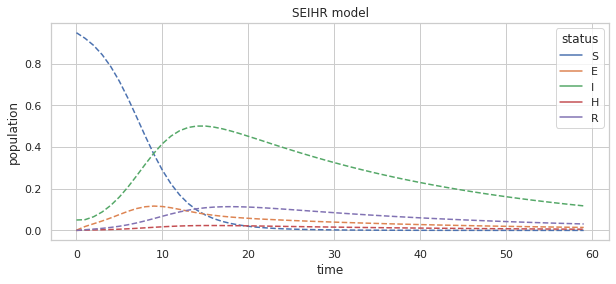

In [5]:
model_name = "SEIHR"
populations_names = list(model_name)
data_real = (
    pd.DataFrame(y_train, columns=populations_names)
    .assign(time=t_train)
    .melt(id_vars="time", var_name="status", value_name="population")
)

fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(
    data=data_real,
    x="time",
    y="population",
    hue="status",
    legend=True,
    linestyle="dashed",
    ax=ax
)
ax.set_title(f"{model_name} model")
# fig.savefig(images_path / f"{model_name}_forward.png", dpi=300)
fig.show()

In [6]:
def get_variable_in_search_range(nominal , var, search_range):
    low = nominal * search_range[0]
    up = nominal * search_range[1]
    scale = (up - low) / 2
    tanh_var = tf.tanh(var) if isinstance(var, tf.Variable) else np.tanh(var)
    return scale * tanh_var + scale + low

In [7]:
def pinn(data_t, data_y, parameters, hyperparameters):

    _beta = dde.Variable(0.0)
    # _b = dde.Variable(0.0)
    # _epsilon = dde.Variable(0.0)
    # _r1 = dde.Variable(0.0)
    # _r2 = dde.Variable(0.0)
    # _sigma = dde.Variable(0.0)
    # _gamma = dde.Variable(0.0)
    # _eta = dde.Variable(0.0)
    # _omega = dde.Variable(0.0)
    # _mu1 = dde.Variable(0.0)
    # _mu2 = dde.Variable(0.0)
    # _mu = dde.Variable(0.0)

    variables_list = [
        _beta,
        # _b,
        # _epsilon,
        # _r1,
        # _r2,
        # _sigma,
        # _gamma,
        # _eta,
        # _omega,
        # _mu1,
        # _mu2,
        # _mu
    ]

    def ode(t, y):

        S = y[:, 0:1]
        E = y[:, 1:2]
        I = y[:, 2:3]
        H = y[:, 3:4]
        R = y[:, 4:5]

        beta = get_variable_in_search_range(parameters["beta"], _beta, hyperparameters["search_range"])
        # b = get_variable_in_search_range(parameters["b"], _b, hyperparameters["search_range"])
        # epsilon = get_variable_in_search_range(parameters["epsilon"], _epsilon, hyperparameters["search_range"])
        # r1 = get_variable_in_search_range(parameters["r1"], _r1, hyperparameters["search_range"])
        # r2 = get_variable_in_search_range(parameters["r2"], _r2, hyperparameters["search_range"])
        # sigma = get_variable_in_search_range(parameters["sigma"], _sigma, hyperparameters["search_range"])
        # gamma = get_variable_in_search_range(parameters["gamma"], _gamma, hyperparameters["search_range"])
        # eta = get_variable_in_search_range(parameters["eta"], _eta, hyperparameters["search_range"])
        # omega = get_variable_in_search_range(parameters["omega"], _omega, hyperparameters["search_range"])
        # mu1 = get_variable_in_search_range(parameters["mu1"], _mu1, hyperparameters["search_range"])
        # mu2 = get_variable_in_search_range(parameters["mu2"], _mu2, hyperparameters["search_range"])
        # mu = get_variable_in_search_range(parameters["mu"], _mu, hyperparameters["search_range"])

        dS_dt = dde.grad.jacobian(y, t, i=0)
        dE_dt = dde.grad.jacobian(y, t, i=1)
        dI_dt = dde.grad.jacobian(y, t, i=2)
        dH_dt = dde.grad.jacobian(y, t, i=3)
        dR_dt = dde.grad.jacobian(y, t, i=4)

        return [
            dS_dt - (- beta * S * I * (1 - b) - epsilon * beta * S * E * (1- b) - mu * S ),
            dE_dt - (beta * S * I * (1 - b) + epsilon * beta * S * E * (1- b) - sigma * E + r1 * R - mu * E),
            dI_dt - (sigma * E - gamma * I - eta * I - mu1 * I + r2 * H - mu * I),
            dH_dt - (eta * I - omega * H - mu2 * H - r2 * H - mu * H),
            dR_dt - (gamma * I + omega * H - r1 * R - mu * R)
        ]


    # Geometry
    geom = dde.geometry.TimeDomain(data_t[0, 0], data_t[-1, 0])

    # Boundaries
    def boundary(_, on_initial):
        return on_initial

    # Initial conditions
    # S_0, E_0, I_0, H_0, R_0 = data_y[0, :]
    # ic_S = dde.icbc.IC(geom, lambda x: S_0, boundary, component=0)
    # ic_E = dde.icbc.IC(geom, lambda x: E_0, boundary, component=1)
    # ic_I = dde.icbc.IC(geom, lambda x: I_0, boundary, component=2)
    # ic_H = dde.icbc.IC(geom, lambda x: H_0, boundary, component=3)
    # ic_R = dde.icbc.IC(geom, lambda x: R_0, boundary, component=4)

    observed_S = dde.icbc.PointSetBC(data_t, data_y[:, 0:1], component=0)
    observed_E = dde.icbc.PointSetBC(data_t, data_y[:, 1:2], component=1)
    observed_I = dde.icbc.PointSetBC(data_t, data_y[:, 2:3], component=2)
    observed_H = dde.icbc.PointSetBC(data_t, data_y[:, 3:4], component=3)
    observed_R = dde.icbc.PointSetBC(data_t, data_y[:, 4:5], component=4)

    data = dde.data.PDE(
        geom,
        ode,
        [
            # ic_S,
            # ic_E,
            # ic_I,
            # ic_H,
            # ic_R,
            observed_S,
            observed_E,
            observed_I,
            observed_H,
            observed_R
        ],
        num_domain=256,
        num_boundary=2,
        anchors=data_t,
    )

    neurons = hyperparameters["neurons"]
    layers = hyperparameters["layers"]
    activation = hyperparameters["activation"]
    net = dde.nn.FNN([1] + [neurons] * layers + [5], activation, "Glorot uniform")

    def feature_transform(t):
        # t = 0.01 * t
        t = t / t_train[-1, 0]
        return tf.concat(
            (
                t,
                tf.sin(t),
                tf.sin(2 * t),
                tf.sin(3 * t),
                tf.sin(4 * t),
                tf.sin(5 * t),
            ),
            axis=1,
        )

    net.apply_feature_transform(feature_transform)

    variable = dde.callbacks.VariableValue(
        variables_list,
        period=100,
        filename=f"{model_name}_variables.dat"
    )

    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        loss_weights = hyperparameters["loss_weights"],
        external_trainable_variables=variables_list
    )
    losshistory, train_state = model.train(
        iterations=hyperparameters["iterations"],
        display_every=10000,
        callbacks=[variable]
    )

    model.compile("L-BFGS", external_trainable_variables=vars)
    losshistory, train_state = model.train(callbacks = [variable])

    dde.saveplot(losshistory, train_state, issave=False, isplot=False)

    parameters_pred = {
        name: get_variable_in_search_range(nominal, var, hyperparameters["search_range"])
        for (name, nominal), var in zip(parameters.items(), variable.value)
    }

    return model, losshistory, train_state, parameters_pred, variable

In [8]:
hyperparameters = {
    "search_range":(0.2, 1.8),
    "iterations": 10000,
    "layers": 3,
    "neurons": 64,
    "activation": "relu",
    "loss_weights": [
        # 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1,
        1, 1, 1, 1, 1
    ]
}

model, losshistory, train_state, parameters_pred, variable = pinn(
    data_t=t_train,
    data_y=y_train,
    parameters=parameters_real,
    hyperparameters=hyperparameters
    )

Compiling model...
Building feed-forward neural network...
'build' took 0.063481 s



/home/aoguedao/mambaforge/envs/pinn/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+258=258. 
  warnings.warn("The balance properties of Sobol' points require "
/home/aoguedao/mambaforge/envs/pinn/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2024-04-15 12:53:12.434674: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 12:53:12.436691: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] cou

'compile' took 2.637871 s

Initializing variables...


2024-04-15 12:53:15.037869: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2024-04-15 12:53:15.129357: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x7f4a08014610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-15 12:53:15.129416: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-04-15 12:53:15.197964: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-15 12:53:15.238583: I tensorflow/compiler/jit/xla_compilation_cache.cc:478] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training model...



2024-04-15 12:53:15.365342: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


Step      Train loss                                                                                              Test loss                                                                                               Test metric
0         [8.12e-07, 8.58e-03, 8.77e-03, 5.83e-03, 5.21e-03, 9.39e-02, 1.11e-02, 1.23e-01, 7.89e-03, 9.13e-04]    [8.12e-07, 8.58e-03, 8.77e-03, 5.83e-03, 5.21e-03, 9.39e-02, 1.11e-02, 1.23e-01, 7.89e-03, 9.13e-04]    []  
10000     [1.00e-06, 6.31e-07, 7.43e-07, 8.34e-07, 4.39e-07, 1.16e-07, 4.20e-07, 2.49e-06, 5.69e-07, 1.66e-07]    [1.00e-06, 6.31e-07, 7.43e-07, 8.34e-07, 4.39e-07, 1.16e-07, 4.20e-07, 2.49e-06, 5.69e-07, 1.66e-07]    []  

Best model at step 10000:
  train loss: 7.40e-06
  test loss: 7.40e-06
  test metric: []

'train' took 39.954100 s

Compiling model...
'compile' took 1.204363 s



2024-04-15 12:53:56.367666: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1750] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).


Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
10000     [1.00e-06, 6.31e-07, 7.43e-07, 8.34e-07, 4.39e-07, 1.16e-07, 4.20e-07, 2.49e-06, 5.69e-07, 1.66e-07]    [1.00e-06, 6.31e-07, 7.43e-07, 8.34e-07, 4.39e-07, 1.16e-07, 4.20e-07, 2.49e-06, 5.69e-07, 1.66e-07]    []  


2024-04-15 12:54:01.993030: I tensorflow/stream_executor/gpu/asm_compiler.cc:323] ptxas warning : Registers are spilled to local memory in function 'fusion_38', 36 bytes spill stores, 40 bytes spill loads



INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000002
  Number of iterations: 29
  Number of functions evaluations: 93
10093     [7.93e-07, 3.53e-07, 6.47e-07, 1.46e-07, 2.35e-07, 5.10e-08, 2.80e-08, 4.63e-08, 1.86e-08, 1.67e-08]    [7.93e-07, 3.53e-07, 6.47e-07, 1.46e-07, 2.35e-07, 5.10e-08, 2.80e-08, 4.63e-08, 1.86e-08, 1.67e-08]    []  

Best model at step 10093:
  train loss: 2.34e-06
  test loss: 2.34e-06
  test metric: []

'train' took 6.590601 s



In [9]:
t_pred =  np.arange(0, n_days, 1)[:, np.newaxis]
y_pred = model.predict(t_pred)
data_pred = (
    pd.DataFrame(y_pred, columns=populations_names, index=t_pred.ravel())
    .rename_axis("time")
    .reset_index()
    .melt(id_vars="time", var_name="status", value_name="population")
)

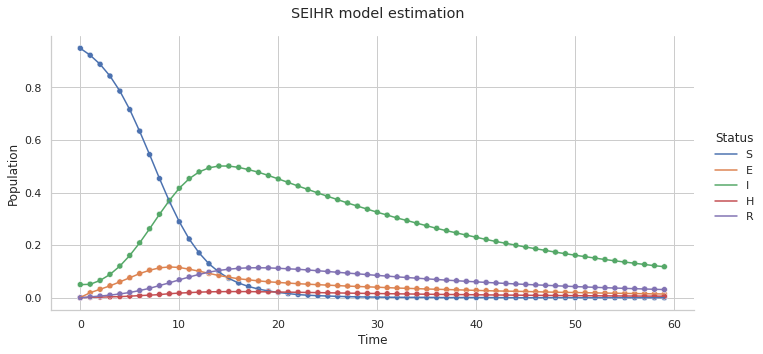

In [10]:
g = sns.relplot(
    data=data_pred,
    x="time",
    y="population",
    hue="status",
    kind="line",
    aspect=2,
)

sns.scatterplot(
    data=data_real,
    x="time",
    y="population",
    hue="status",
    ax=g.ax,
    legend=False
)

(
    g.set_axis_labels("Time", "Population")
    .tight_layout(w_pad=1)
)

g._legend.set_title("Status")
g.figure.subplots_adjust(top=0.9)
g.figure.suptitle(f"{model_name} model estimation")
plt.savefig(images_path / f"{model_name}_pinn.png", dpi=300)
plt.show()

In [11]:
lines = open(f"{model_name}_variables.dat", "r").readlines()
raw_parameters_pred_history = np.array(
    [
         np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)

iterations = [int(re.findall("^[0-9]+", line)[0]) for line in lines]

parameters_pred_history = {   
    name: get_variable_in_search_range(nominal, raw_parameters_pred_history[:, i], hyperparameters["search_range"])
    for i, (name, nominal) in enumerate(parameters_real.items())
}

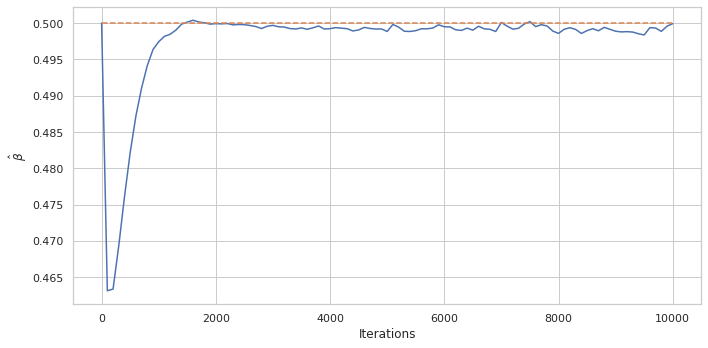

In [18]:
n_callbacks, n_variables = raw_parameters_pred_history.shape
fig, ax = plt.subplots(sharex=True, figsize=(10, 5))
parameter = "beta"
ax.plot(iterations, parameters_pred_history[parameter] , "-", label="Predicted")
ax.plot(iterations, np.ones_like(iterations) * parameters_real[parameter], "--", label="Real")
ax.legend()
ax.set_ylabel(r"$\hat{\beta}$")
ax.set_xlabel("Iterations")
fig.suptitle(f"Learning Curve model {model_name} using PINNs")
fig.tight_layout()
fig.savefig(images_path / f"{model_name}_pinn_parameter_estimation.png", dpi=300)

In [19]:
error_df = (
    pd.DataFrame(
        {
            "Real": parameters_real,
            "Predicted": parameters_pred
        }
    )
    .assign(
        **{"Relative Error": lambda x: (x["Real"] - x["Predicted"]).abs() / x["Real"]}
    )
)
error_df

,Real,Predicted,Relative Error
beta,0.5,0.499918,0.000164
